# **Задание: Улучшите результаты нейросети CharRnn, используя большую и/или лучше сформированную сеть**

Справка: CharRnn решает задачу многоклассовой классификации имен по национальностям: Ivan - Russia, Nishimora - Japan и т.д. Ваша задача - улучшить решени, используя более продвинутую архитектуру.

•  Настройте гиперпараметры для повышения производительности, такие как: количество эпох, размер батча и скорость обучения (lr).  
•  Протестируйте слои nn.LSTM и nn.GRU  
•  Измените размер слоев, например, увеличив глубину, добавив специальные слои  
•  Объедините несколько этих RNN в сеть более высокого уровня

**Важно!** Ваш написанный код должен быть задокументирован (комментарии в коде или доп. ячейки в местах архитекутры сети).


---


Критерии:

1) Протестирована сеть GRU, написаны выводы по ней (2 балла)  
2) Протестирована сеть LSTM, написаны выводы по ней (Примечание: посмотрите, что возвращает nn.LSTM: возможно, что-то лишнее, что нужно будет учесть в функции forward вашей НС) (3 балла)  
3) Протестирована глубокая нейросеть: несколько **рекуррентных слоев** описана мотивировка выбора количества слоев и ее архитектуры (2 балла)  
4) Протестирована глубокая нейросеть: несколько **рекуррентных и несколько линейных слоев** описана мотивировка выбора количества слоев и ее архитектуры (2 балла)

In [ ]:
import torch

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Используем {torch.get_default_device()}")

Используем cpu


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


Подготовка данных
==================


In [ ]:
import string
import unicodedata

allowed_characters = string.ascii_letters + " .,;'"
n_letters = len(allowed_characters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

Для начала переведем все на Ascii, пример ниже:


In [ ]:
print (f"Конвертация 'Ślusàrski' в {unicodeToAscii('Ślusàrski')}")

Конвертация 'Ślusàrski' в Slusarski


Переводим имена в тензоры
==========================

Теперь, когда у нас есть все имена, нам нужно преобразовать их в Тензоры, чтобы иметь возможность их использовать.

Для представления одной буквы мы используем "one-hot вектор" размера <1 x n_letters>. One-hot вектор заполнен нулями, за исключением единицы в индексе текущей буквы, например, "b" = <0 1 0 0 0 ...>.

Чтобы создать слово, мы объединяем несколько таких векторов в 2D-матрицу <длина_строки x 1 x n_letters>.

Эта дополнительная размерность 1 нужна, потому что PyTorch предполагает, что все находится в батчах - здесь мы просто используем размер батча, равный 1.

In [ ]:
def letterToIndex(letter):
    return allowed_characters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

Пример использования `lineToTensor()` для разных строк


In [ ]:
print (f"Символ 'a' переходит в тензор {lineToTensor('a')}")
print (f"Строка 'Ahn' переходит в тензор {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

Символ 'a' переходит в тензор tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])
Строка 'Ahn' переходит в тензор tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset



class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.load_time = time.localtime
        labels_set = set()

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

Загружаем примеры в `NamesDataset`


In [ ]:
alldata = NamesDataset("data/names")
print(f"загрузили {len(alldata)} примеров имен")
print(f"Пример имени: {alldata[0]}")

загрузили 20074 примеров имен
Пример имени: (tensor([17]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Конвертируем в датасет используя  `torch.utils.data`


In [ ]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train примеры = {len(train_set)}, validation примеры = {len(test_set)}")

train примеры = 17063, validation примеры = 3011


Всего  **20074** примеров


Задание 0. Создаем базовую нейросеть для классификации имен по национальностям (задание здесь)
===================


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Пример сети, которая бует решать задачу классификации имен по национальностям
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size) # Используем Обычную RNN
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # Используем функцию ошибки для многоклассовой классификации

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)

        return output

# Создайте аналогичный класс, изменив его архитектуру по критериям, описанным в начале блокнота и обучите его, используя функцию ниже. Протестируйте каждую модель.
## Подпишите все ваши блоки кода: к какому заданию относятся, задокументируйте основные моменты, как в примере выше.

In [ ]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(57, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


После этого мы можем передать наш Тензор в RNN, чтобы получить предсказанный результат. Впоследствии мы используем вспомогательную функцию, label_from_output, чтобы получить текстовую метку для класса.


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input)
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-3.0191, -2.9647, -2.9447, -3.0054, -2.9230, -2.7741, -2.7051, -2.9474,
         -2.9254, -2.7655, -2.9929, -2.9949, -2.7364, -2.8400, -2.9730, -2.8509,
         -2.9429, -2.8088]], grad_fn=<LogSoftmaxBackward0>)
('Japanese', 6)


*Обучение*
========


Обучение нейросети (здесь задание)
====================

Теперь, чтобы обучить эту сеть, достаточно показать ей кучу примеров, позволить ей делать предположения и сообщать, если она не права.

Мы делаем это, определя функцию train(), которая обучает модель на заданном наборе данных, используя мини-батчи. RNN (рекуррентные нейронные сети) обучаются аналогично другим сетям; поэтому для полноты мы включаем здесь метод пакетного обучения. Цикл (for i in batch) вычисляет потери для каждого элемента в пакете перед корректировкой весов. Эта операция повторяется до достижения количества эпох.


In [ ]:
import random
import numpy as np

def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"Обучаем с количеством сэмплов n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t Средняя ошибка по батчу = {all_losses[-1]}")
        current_loss = 0

    return all_losses

Теперь мы можем обучить набор данных с мини-батчами в течение указанного количества эпох. Количество эпох для этого примера уменьшено для ускорения сборки. Вы можете получить лучшие результаты с другими параметрами.


In [ ]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"обучение заняло {end-start} секунд")

Обучаем с количеством сэмплов n = 17063
5 (19%): 	 Средняя ошибка по батчу = 0.8901948915905453
10 (37%): 	 Средняя ошибка по батчу = 0.7060237163681042
15 (56%): 	 Средняя ошибка по батчу = 0.5942659732783855
20 (74%): 	 Средняя ошибка по батчу = 0.5030203256142008
25 (93%): 	 Средняя ошибка по батчу = 0.4475955270674616
обучение заняло 662.0409185886383 секунд


1. Настраиваем гиперпараметры для повышения производительности, изменила  скорость обучения (lr)=0,01 - уменьшила, чтобы проверить влияние параметра на процесс обучения


In [ ]:

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)

        return output

start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.01, report_every=5)
end = time.time()
print(f"обучение заняло {end-start} секунд")

Визуализируем результаты
====================


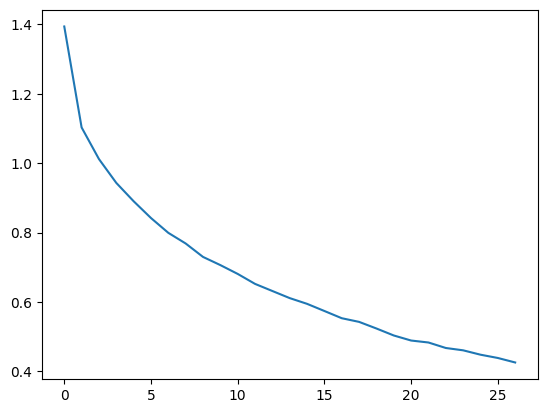

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

ПОлученный график говорит о низком значении скорости обучения, поэтому в следующих эксперирментах попроьую опять увеличить.

Измеряем эффективность модели
======================

Чтобы увидеть, насколько хорошо сеть работает с разными категориями, мы создадим матрицу ошибок, указывающую для каждого фактического языка (строки), какой язык сеть угадывает (столбцы). Чтобы вычислить матрицу ошибок, через сеть прогоняется набор образцов с помощью функции evaluate(), которая аналогична функции train(), за исключением отсутствия обратного распространения (backprop).


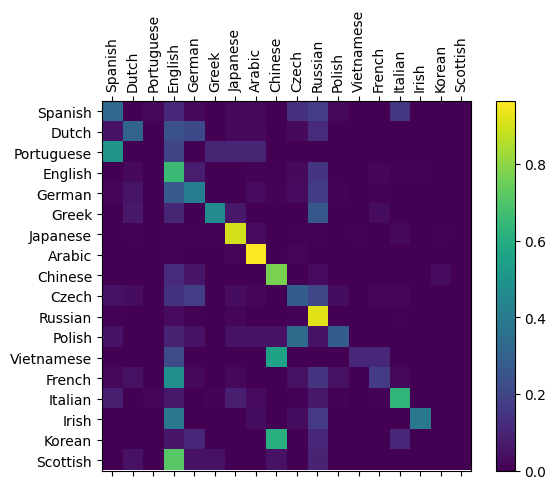

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval()
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)

Матрица ошибок визуализирует информацию о точности классификации сети для каждого из классов. Результаты позволяют сделать вывод о том, что отсутствует явное преобладание главной диагонали - сеть точно классифицировала только 4 класса.

**Усложнение архитектуры сети** - замена рекуррентного слоя на  GRU и слои LSTM с однаковыми параметрами скрытого простраства n_hidden = 128. При обучении использовала идентичные параметры для каждого слоя - n_epoch=10, n_batch_size=64, learning_rate=0.2. Опять увеличила learning_rate, так как усложнила архитектуры и сначала проверю обучение на большем значении параметра.

# GRU и LSTM

In [ ]:
import torch.nn as nn

class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        gru_out, hidden = self.gru(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        lstm_out, (hidden, cell) = self.lstm(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


n_hidden = 128
char_gru = CharGRU(n_letters, n_hidden, len(alldata.labels_uniq))
char_lstm = CharLSTM(n_letters, n_hidden, len(alldata.labels_uniq))

print(char_gru)
print(char_lstm)


CharGRU(
  (gru): GRU(57, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
CharLSTM(
  (lstm): LSTM(57, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = char_gru(input)
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.7969, -2.9047, -2.8926, -2.7791, -2.9495, -2.9651, -2.8976, -2.8892,
         -2.9554, -2.8683, -2.8501, -2.9927, -2.7790, -2.9008, -2.8585, -2.8715,
         -2.9499, -2.9608]], grad_fn=<LogSoftmaxBackward0>)
('Vietnamese', 12)


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = char_lstm(input)
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.9718, -2.9963, -2.8027, -2.9768, -2.8568, -2.8872, -2.9984, -2.8080,
         -2.8921, -2.9258, -2.9013, -2.9380, -2.8652, -2.8321, -2.8874, -2.7796,
         -2.8803, -2.8634]], grad_fn=<LogSoftmaxBackward0>)
('Irish', 15)


In [ ]:
def train(rnn, training_data, testing_data, n_epoch=10, n_batch_size=64, report_every=5, learning_rate=0.2, criterion=nn.NLLLoss()):
    train_losses = []
    test_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        current_train_loss = 0
        for batch in batches:
            batch_loss = 0
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            current_train_loss += batch_loss.item() / len(batch)

        train_losses.append(current_train_loss / len(batches))
        test_loss = evaluate_loss(rnn, testing_data, criterion)
        test_losses.append(test_loss)

        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): Train Loss = {train_losses[-1]}, Test Loss = {test_loss}")

    return train_losses, test_losses


In [ ]:

def evaluate_loss(rnn, testing_data, criterion):
    rnn.eval()
    total_loss = 0
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            loss = criterion(output, label_tensor)
            total_loss += loss.item()
    return total_loss / len(testing_data)


In [ ]:
n_hidden = 128
char_gru = CharGRU(n_letters, n_hidden, len(alldata.labels_uniq))
char_lstm = CharLSTM(n_letters, n_hidden, len(alldata.labels_uniq))

In [ ]:
def plot_train_test_losses(train_losses, test_losses, title):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(title)
    plt.xlabel("Эпоха")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.show()

Обучение CharGRU...
5 (19%): Train Loss = 0.6375422451832585, Test Loss = 0.7007408348809245
10 (37%): Train Loss = 0.488749811809538, Test Loss = 0.5852650317700442
15 (56%): Train Loss = 0.35829101926402046, Test Loss = 0.6149999538216196
20 (74%): Train Loss = 0.2461683434879697, Test Loss = 0.6793239023776512
25 (93%): Train Loss = 0.1696422578007448, Test Loss = 0.7591291420268319
обучение заняло 1589.539467573166 секунд


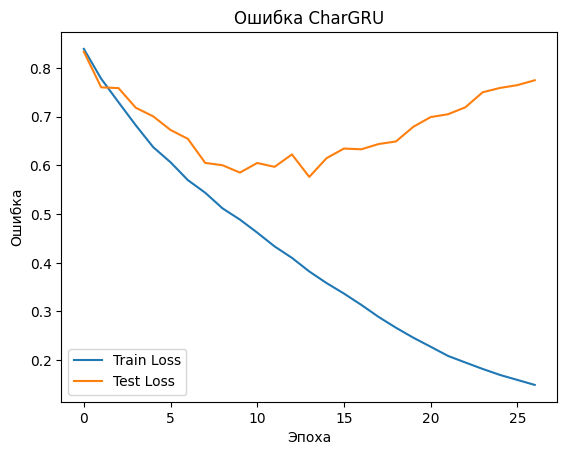

In [ ]:
print("Обучение CharGRU...")
start = time.time()
gru_train_losses, gru_test_losses = train(char_gru, train_set, test_set, n_epoch=27, learning_rate=0.15)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(gru_train_losses, gru_test_losses, "Ошибка CharGRU")


**График обучения для следующих парметров - рекуррентный слоя  GRU**  
n_hidden = 128, n_epoch=10, n_batch_size=64, learning_rate=0.2.
График обучения показывает явное переобучение сети уже с 10 эпохи.
Следовательно,  необходимо упростить архитектуру, но я меня всего один слой GRU, поэтому добавлю слой dropout

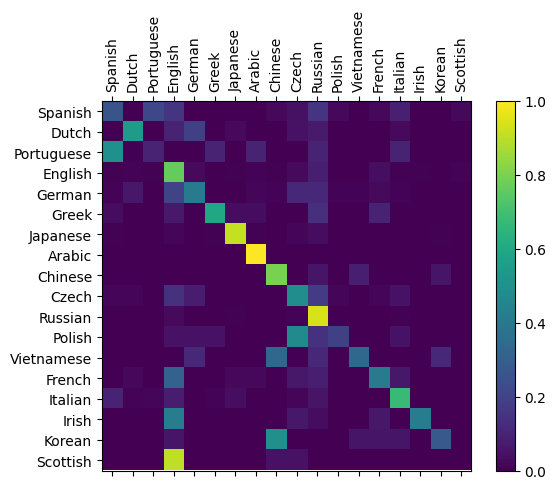

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval()
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



evaluate(char_gru, test_set, classes=alldata.labels_uniq)

**Выводы по GRU**
- долго работала по сравнению с обычной rnn
- наблюдается переобучение
- добавлю далее дропаут..
- преобладание диагональной матрицы говорит о том, что межклассовая точность повысилась

Обучение CharLSTM...
5 (19%): Train Loss = 0.9003333310504537, Test Loss = 0.940121915584391
10 (37%): Train Loss = 0.6730061115618383, Test Loss = 0.7055029329471526
15 (56%): Train Loss = 0.5358658616617968, Test Loss = 0.6368485844147248
20 (74%): Train Loss = 0.431421821907878, Test Loss = 0.6183132682813435
25 (93%): Train Loss = 0.34022839391133286, Test Loss = 0.6419864883144345
обучение заняло 899.4829514026642 секунд


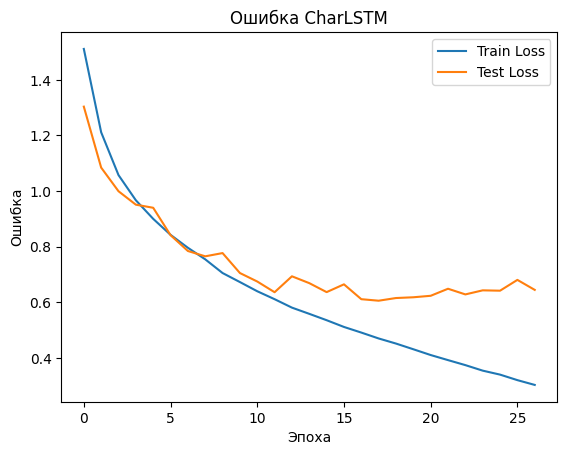

In [ ]:
print("Обучение CharLSTM...")
start = time.time()
lstm_train_losses, lstm_test_losses = train(char_lstm, train_set, test_set, n_epoch=27, learning_rate=0.15)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(lstm_train_losses, lstm_test_losses, "Ошибка CharLSTM")

**График обучения для следующих парметров - рекуррентный слоя LSTM**
n_hidden = 128, n_epoch=10, n_batch_size=64, learning_rate=0.2. График обучения показывает возможно небольшое переобучение, но, возможно нужно усложнить архитектуру и добавть слои LSTM или увеличить количество эпох.

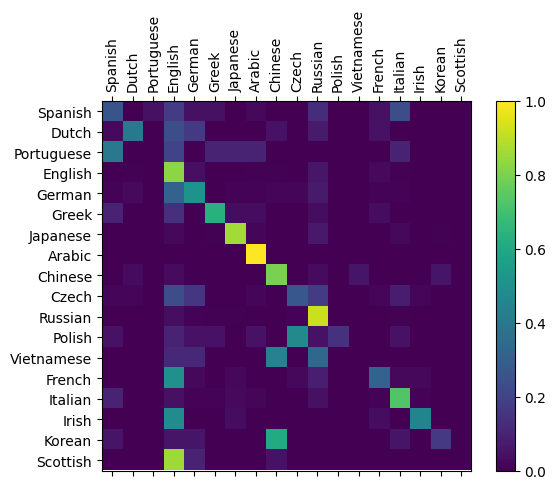

In [ ]:
evaluate(char_lstm, test_set, classes=alldata.labels_uniq)

**Выводы по LSTM**
Сеть показала лучште результаты по сравнению с обчной RNN и GRU. Возможно, нужно остановиться именно на этой архитектуре и попробовать другие значения lr.
Выводы:
- возвращает 2 переменные (hidden, cell), поэтому в foward только hidden[0] возвращается
- также есть небольшое переобучения, но позднее
- работало на удивление быстрее
- далее изменю lr и количество эпох

# **Изменение lr, количества эпох, n_hidden**

Для архитектур GRU и LSTM учложно архитектуру  - увеличим n_hidden = 256, поменяю  параметры обучения  - уменьшение learning_rate=0.01

In [ ]:
import torch.nn as nn

class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        gru_out, hidden = self.gru(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        lstm_out, (hidden, cell) = self.lstm(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


n_hidden = 256
char_gru = CharGRU(n_letters, n_hidden, len(alldata.labels_uniq))
char_lstm = CharLSTM(n_letters, n_hidden, len(alldata.labels_uniq))

print(char_gru)
print(char_lstm)


CharGRU(
  (gru): GRU(57, 256)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
CharLSTM(
  (lstm): LSTM(57, 256)
  (fc): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Обучение CharGRU...
5 (25%): Train Loss = 1.3328037668232837, Test Loss = 1.3123764393828001
10 (50%): Train Loss = 1.1702289223395173, Test Loss = 1.165597092412961
15 (75%): Train Loss = 1.068113919566862, Test Loss = 1.064193052949708
20 (100%): Train Loss = 1.0056338135461163, Test Loss = 1.0027071414683248
обучение заняло 1885.9443583488464 секунд


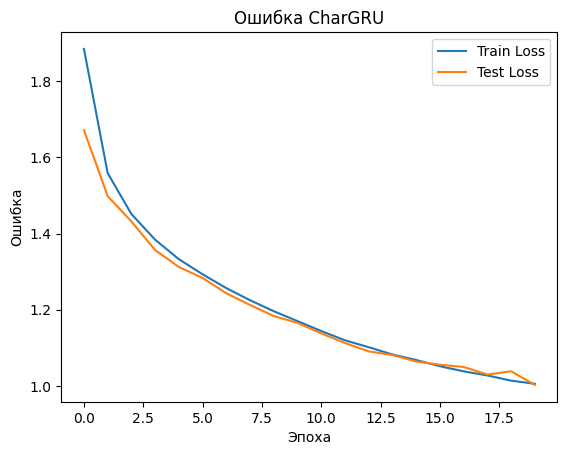

In [ ]:
print("Обучение CharGRU...")
start = time.time()
gru_train_losses, gru_test_losses = train(char_gru, train_set, test_set, n_epoch=20, learning_rate=0.01)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(gru_train_losses, gru_test_losses, "Ошибка CharGRU")


**График обучения для следующих парметров - рекуррентный слоя GRU**
**n_hidden = 256, n_epoch=20, n_batch_size=64, learning_rate=0.01. **
График обучения показывает отсутствие переобучения сети.

loss падает, значит надо продолжить обучение на большем количестве эпох. однако, это долго, поэтому попробую еще раз изменить параметры или возможно дело в hidden...
долго работает, поэтому с таким lr слои добавлять не буду, но заметно лучше

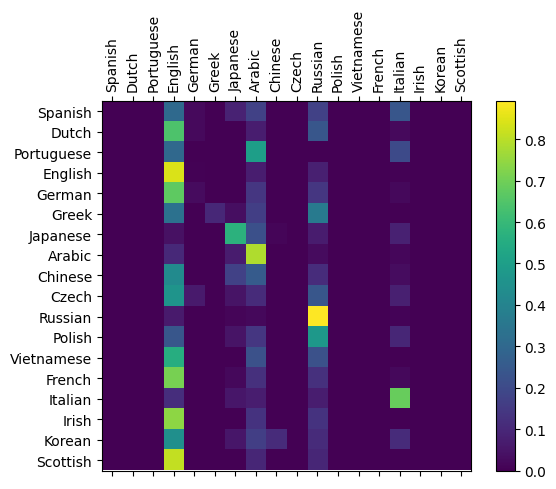

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval()
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



evaluate(char_gru, test_set, classes=alldata.labels_uniq)

Однако, матрица ошибок свидетельствует об отсутствии преобладания главной диагонали - плохое значения точности классификации.

Обучение CharLSTM...
5 (19%): Train Loss = 0.9458678047735612, Test Loss = 0.9173381270332428
10 (37%): Train Loss = 0.7255678937744033, Test Loss = 0.7589969611245222
15 (56%): Train Loss = 0.565980173608621, Test Loss = 0.6212489204590154
20 (74%): Train Loss = 0.44989588889705434, Test Loss = 0.6196424642754212
25 (93%): Train Loss = 0.34866928677335857, Test Loss = 0.6579958754212137
обучение заняло 1880.7223234176636 секунд


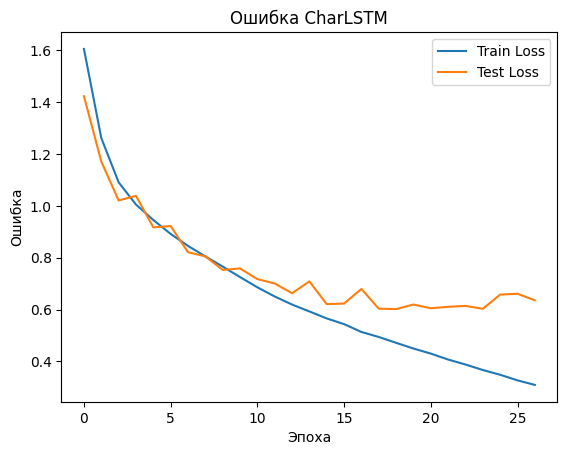

In [ ]:
print("Обучение CharLSTM...")
start = time.time()
lstm_train_losses, lstm_test_losses = train(char_lstm, train_set, test_set, n_epoch=27, learning_rate=0.15)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(lstm_train_losses, lstm_test_losses, "Ошибка CharLSTM")

**График обучения для следующих парметров - рекуррентный слоя LSTM** *n_hidden = 256, n_epoch=20, n_batch_size=64, learning_rate=0.01. *
График обучения показывает опять переобучение.
Вероятно при усложнении архитектуры будет большее переобучение. Попробую другие параметры и dropout

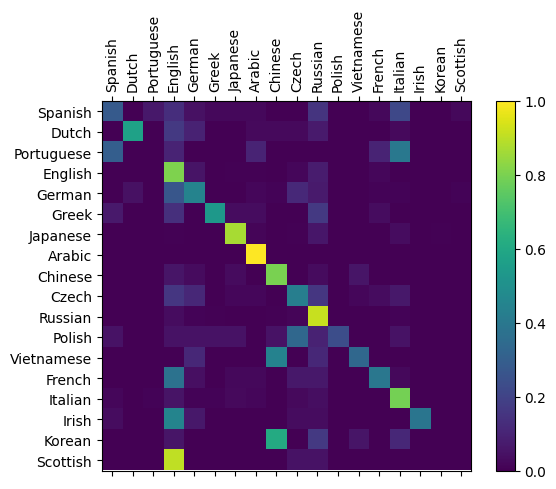

In [ ]:
evaluate(char_lstm, test_set, classes=alldata.labels_uniq)

Матрица ошибок показывает, что модель с высокой точностью предсказывает истинные метки практически для каждого класса
присутствует перевес в точности для 3  классов - Portugues, Korean, Scottish.


**GRU и LSTM**
*n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.05 **

возвращение 128 и чуть увеличение lr

In [ ]:
import torch.nn as nn

class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        gru_out, hidden = self.gru(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        lstm_out, (hidden, cell) = self.lstm(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


n_hidden = 128
char_gru = CharGRU(n_letters, n_hidden, len(alldata.labels_uniq))
char_lstm = CharLSTM(n_letters, n_hidden, len(alldata.labels_uniq))

print(char_gru)
print(char_lstm)


CharGRU(
  (gru): GRU(57, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
CharLSTM(
  (lstm): LSTM(57, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Обучение CharGRU...
5 (20%): Train Loss = 1.0244484876469424, Test Loss = 1.0115471423659665
10 (40%): Train Loss = 0.8785747769666311, Test Loss = 0.8808377388637012
15 (60%): Train Loss = 0.7783012487455349, Test Loss = 0.8244706485300123
20 (80%): Train Loss = 0.6973245781804869, Test Loss = 0.7397298235750401
25 (100%): Train Loss = 0.6293136210645671, Test Loss = 0.7105555100539861
обучение заняло 1477.511467218399 секунд


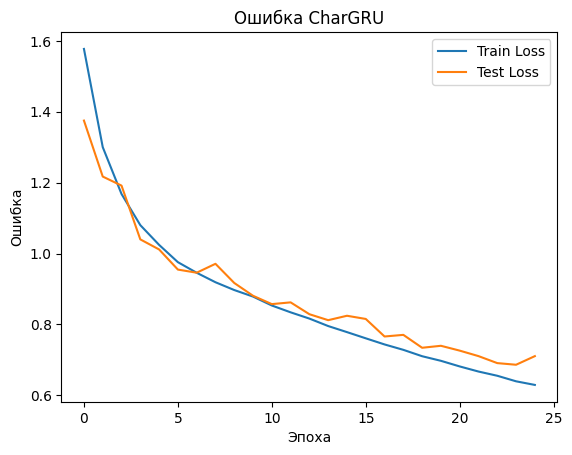

In [ ]:
print("Обучение CharGRU...")
start = time.time()
gru_train_losses, gru_test_losses = train(char_gru, train_set, test_set, n_epoch=25, learning_rate=0.05)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(gru_train_losses, gru_test_losses, "Ошибка CharGRU")


**График обучения для следующих парметров - рекуррентный слоя GRU** *n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.05.
Переобучения нет вероятно оптимальные параметры, но нужно увеличить количество эпох, график схож с LSTM  с аналогичными параметрами

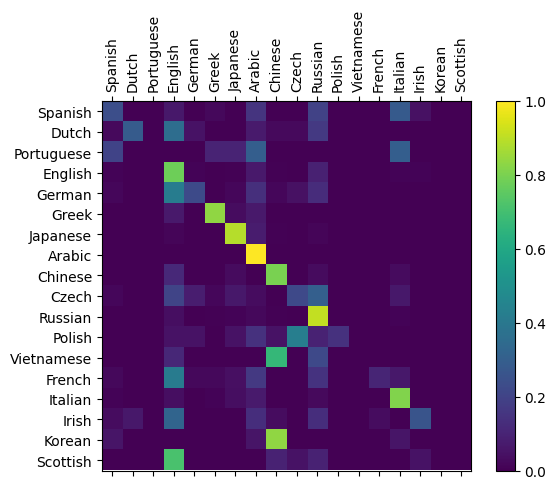

In [ ]:
evaluate(char_gru, test_set, classes=alldata.labels_uniq)

Обучение CharLSTM...
5 (20%): Train Loss = 1.1211703518831089, Test Loss = 1.0858992381455164
10 (40%): Train Loss = 0.929033965127464, Test Loss = 0.9317616147483161
15 (60%): Train Loss = 0.8183807010902981, Test Loss = 0.8421416677558813
20 (80%): Train Loss = 0.7431949539895413, Test Loss = 0.8254314257653297
25 (100%): Train Loss = 0.6770272754688633, Test Loss = 0.7109835935183582
обучение заняло 828.874443769455 секунд


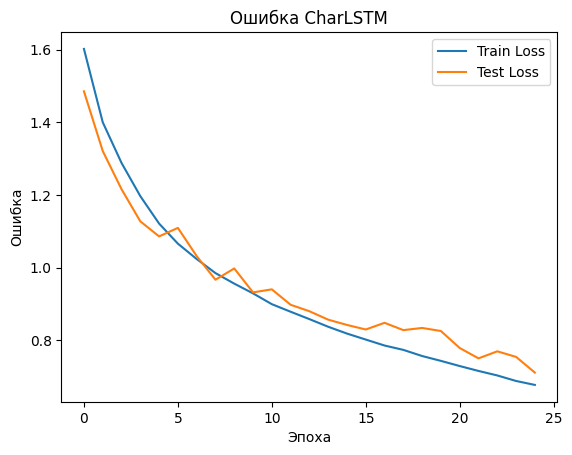

In [ ]:
print("Обучение CharLSTM...")
start = time.time()
lstm_train_losses, lstm_test_losses = train(char_lstm, train_set, test_set, n_epoch=25, learning_rate=0.05)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(lstm_train_losses, lstm_test_losses, "Ошибка CharLSTM")

**График обучения для следующих парметров - рекуррентный слоя LSTM** *n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.05.
Переобучения нет, вероятно оптимальные параметры, но нужно увеличить количество эпох

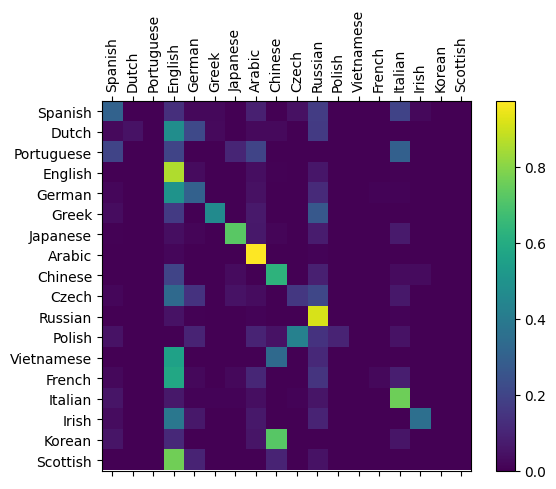

In [ ]:
evaluate(char_lstm, test_set, classes=alldata.labels_uniq)

**Архитектуры GRU. LSTM с dropout**
и увеличим learning_rate=0.2

In [ ]:
import torch.nn as nn

class CharGRU_2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU_2, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        gru_out, hidden = self.gru(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


class CharLSTM_2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM_2, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        lstm_out, (hidden, cell) = self.lstm(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


n_hidden = 128
char_gru_2 = CharGRU_2(n_letters, n_hidden, len(alldata.labels_uniq))
char_lstm_2 = CharLSTM_2(n_letters, n_hidden, len(alldata.labels_uniq))

print(char_gru_2)
print(char_lstm_2)


CharGRU_2(
  (gru): GRU(57, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): LogSoftmax(dim=1)
)
CharLSTM_2(
  (lstm): LSTM(57, 128)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


Обучение CharGRU...
5 (20%): Train Loss = 0.7708406810266838, Test Loss = 0.7733590048799514
10 (40%): Train Loss = 0.5250466153982266, Test Loss = 0.6022043157709212
15 (60%): Train Loss = 0.36874070603674103, Test Loss = 0.601398709352178
20 (80%): Train Loss = 0.2376783392491749, Test Loss = 0.6933452007129625
25 (100%): Train Loss = 0.15897430549550773, Test Loss = 0.806439202936415
обучение заняло 1505.9217698574066 секунд


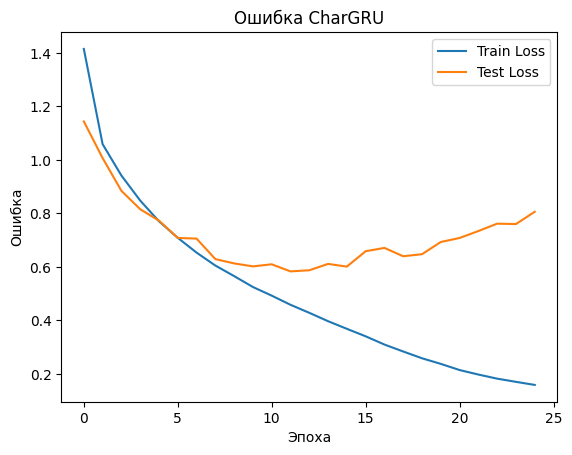

In [ ]:
print("Обучение CharGRU...")
start = time.time()
gru_train_losses, gru_test_losses = train(char_gru_2, train_set, test_set, n_epoch=25, learning_rate=0.2)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(gru_train_losses, gru_test_losses, "Ошибка CharGRU")


**График обучения для следующих парметров - рекуррентный слоя  GRU**  
n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.2.
График обучения показывает явное переобучение сети уже с 10 эпохи.
Следовательно,  слой dropout не помог, Увеличение learning_rate=0.2 плохо влияет на результаты .

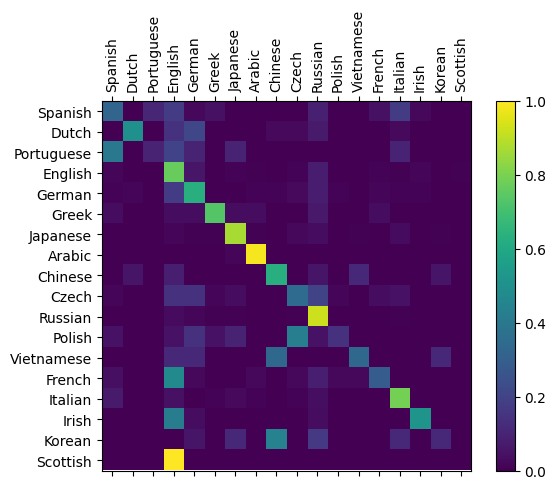

In [ ]:
evaluate(char_gru_2, test_set, classes=alldata.labels_uniq)

Обучение CharLSTM...
5 (20%): Train Loss = 0.8417400849337795, Test Loss = 0.8193172712858009
10 (40%): Train Loss = 0.5965254603489207, Test Loss = 0.6713000535046316
15 (60%): Train Loss = 0.4506968266188995, Test Loss = 0.6243276202272873
20 (80%): Train Loss = 0.3333083763688441, Test Loss = 0.6498081808551235
25 (100%): Train Loss = 0.24494784996279786, Test Loss = 0.7131899520845806
обучение заняло 821.6735126972198 секунд


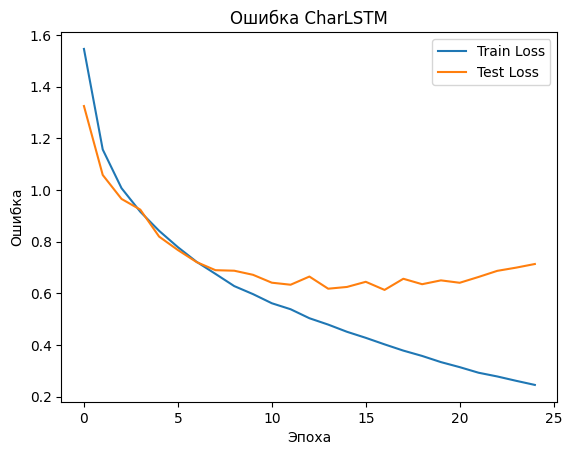

In [ ]:
print("Обучение CharLSTM...")
start = time.time()
lstm_train_losses, lstm_test_losses = train(char_lstm_2, train_set, test_set, n_epoch=25, learning_rate=0.2)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(lstm_train_losses, lstm_test_losses, "Ошибка CharLSTM")

**График обучения для следующих парметров - рекуррентный слоя  LSTM**  
n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.2.
График обучения показывает  переобучение сети.
 Увеличение learning_rate=0.2 плохо влияет на результаты, слой dropout не помог.

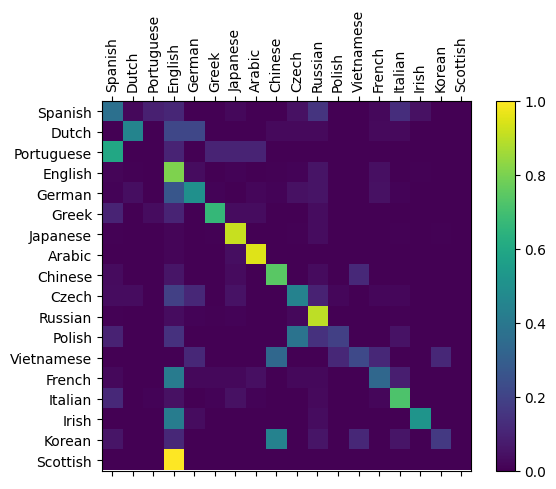

In [ ]:
evaluate(char_lstm_2, test_set, classes=alldata.labels_uniq)

#Глубокая нейросеть
**GRU и LSTM c 3 слоями (num_layers=3)**
n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.2 *

 увеличение lr , так как  долгий процесс обучения

In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = char_lstm(input)
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[ -4.4722,  -3.8783,  -5.9237,  -0.9050,  -1.5867, -10.4287, -12.9576,
         -11.9946, -11.7691,  -4.9011,  -1.2940,  -7.8146,  -9.8971,  -2.7862,
          -5.4389,  -5.8421,  -9.8548,  -5.2955]],
       grad_fn=<LogSoftmaxBackward0>)
('English', 3)


In [ ]:
import torch.nn as nn

class CharGRU_3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CharGRU_3, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        gru_out, hidden = self.gru(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


class CharLSTM_3(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CharLSTM_3, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        lstm_out, (hidden, cell) = self.lstm(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


n_hidden = 128
num_layers=3
char_gru = CharGRU_3(n_letters, n_hidden, num_layers, len(alldata.labels_uniq))
char_lstm = CharLSTM_3(n_letters, n_hidden, num_layers, len(alldata.labels_uniq))

print(char_gru)
print(char_lstm)


CharGRU_3(
  (gru): GRU(57, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
CharLSTM_3(
  (lstm): LSTM(57, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


Обучение CharGRU...
5 (20%): Train Loss = 0.7724030415004495, Test Loss = 0.7735995440532505
10 (40%): Train Loss = 0.5208685265447861, Test Loss = 0.6314191500367666
15 (60%): Train Loss = 0.3576761811523509, Test Loss = 0.6538866152732439
20 (80%): Train Loss = 0.2309178877315937, Test Loss = 0.7367586163380617
25 (100%): Train Loss = 0.1571117201219962, Test Loss = 0.8892487193285272
обучение заняло 4044.6327826976776 секунд


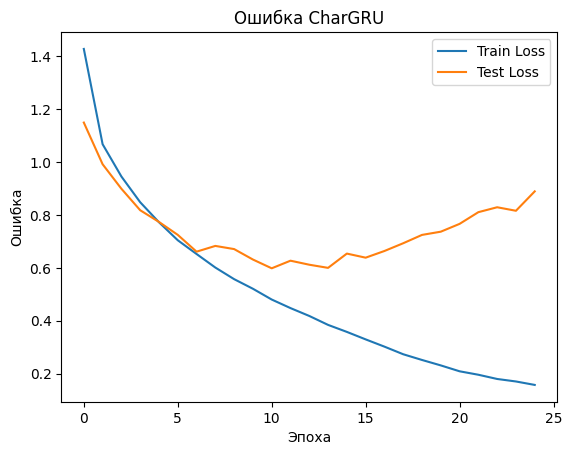

In [ ]:
print("Обучение CharGRU...")
start = time.time()
gru_train_losses_2, gru_test_losses_2 = train(char_gru, train_set, test_set, n_epoch=25, learning_rate=0.2)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(gru_train_losses_2, gru_test_losses_2, "Ошибка CharGRU")


**График обучения для следующих парметров - рекуррентный слоя GRU с 3 слоями**
n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.2.
График обучения показывает переобучение сети. Усложнение архитектуры отрицательно влияет на обучение

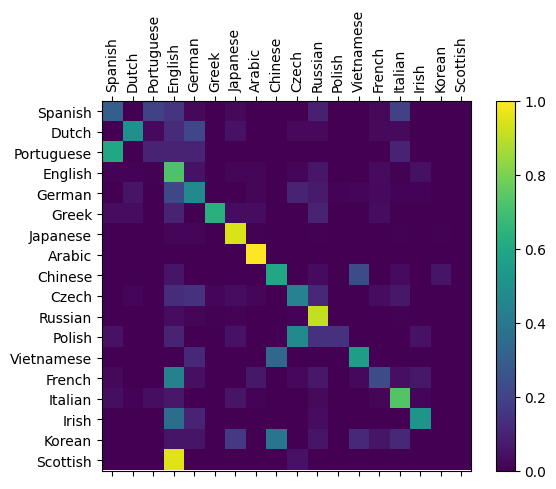

In [ ]:
evaluate(char_gru, test_set, classes=alldata.labels_uniq)

Обучение CharLSTM...
5 (20%): Train Loss = 0.8310389985095014, Test Loss = 0.8450942805975724
10 (40%): Train Loss = 0.588310133111208, Test Loss = 0.6522998842308338
15 (60%): Train Loss = 0.4480690222735554, Test Loss = 0.6096589113911853
20 (80%): Train Loss = 0.33483670918909786, Test Loss = 0.6392312710676258
25 (100%): Train Loss = 0.24392015782177895, Test Loss = 0.7211801615665016
обучение заняло 1994.1611516475677 секунд


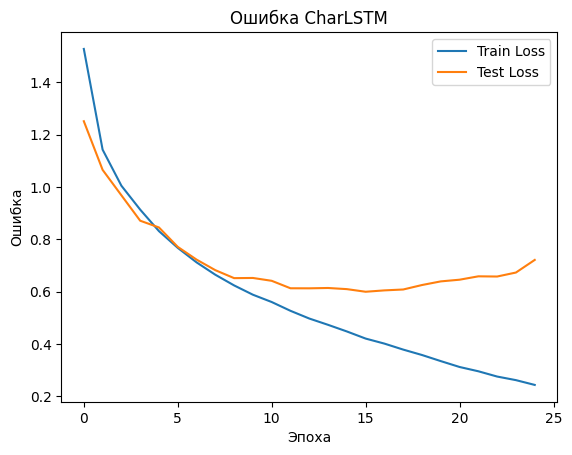

In [ ]:
print("Обучение CharLSTM...")
start = time.time()
lstm_train_losses, lstm_test_losses = train(char_lstm, train_set, test_set, n_epoch=25, learning_rate=0.2)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(lstm_train_losses, lstm_test_losses, "Ошибка CharLSTM")

**График обучения для следующих парметров - рекуррентный слоя LSTM с 3 слоями**
n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.2.
График обучения показывает переобучение сети. Усложнение архитектуры отрицательно влияет на обучение

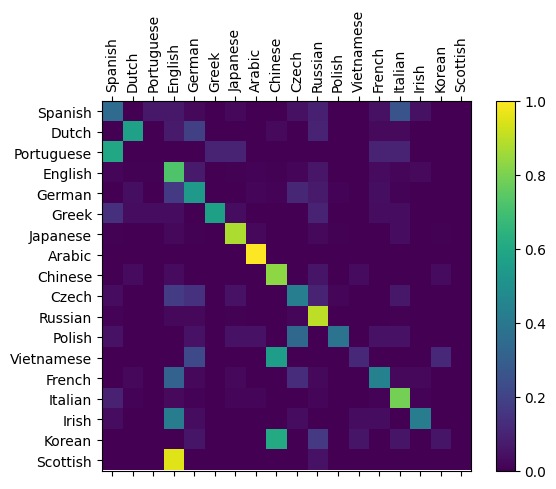

In [ ]:
evaluate(char_lstm, test_set, classes=alldata.labels_uniq)

**Добавление линейного слоя**, 10 эпох (очень долго учится)

Обучение CharGRU...
5 (25%): Train Loss = 0.8473884468377844, Test Loss = 0.8792816827111755
10 (50%): Train Loss = 0.6115552829430929, Test Loss = 0.6384311443500588
15 (75%): Train Loss = 0.45916671638650103, Test Loss = 0.5963845681367468
20 (100%): Train Loss = 0.33659122450510987, Test Loss = 0.6162834164815303
обучение заняло 1114.4912900924683 секунд


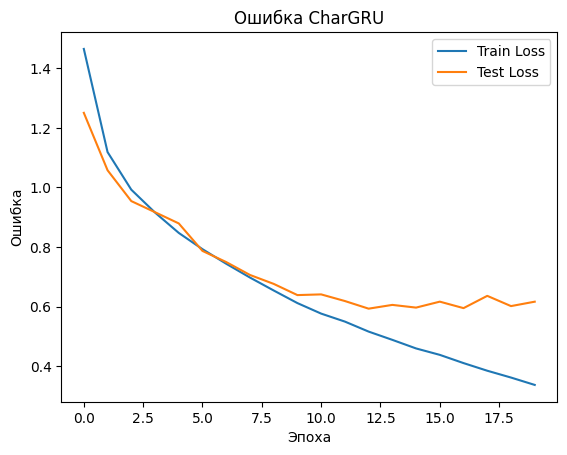

NameError: name 'label_from_output' is not defined

In [ ]:
import torch.nn as nn
import time
import random
import numpy as np
import matplotlib.pyplot as plt

class CharGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        gru_out, hidden = self.gru(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


class CharLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        lstm_out, (hidden, cell) = self.lstm(line_tensor)
        output = self.fc(hidden[0])
        output = self.softmax(output)
        return output


def train(rnn, training_data, testing_data, n_epoch=10, n_batch_size=64, report_every=5, learning_rate=0.2, criterion=nn.NLLLoss()):
    train_losses = []
    test_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        current_train_loss = 0
        for batch in batches:
            batch_loss = 0
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            current_train_loss += batch_loss.item() / len(batch)

        train_losses.append(current_train_loss / len(batches))
        test_loss = evaluate_loss(rnn, testing_data, criterion)
        test_losses.append(test_loss)

        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): Train Loss = {train_losses[-1]}, Test Loss = {test_loss}")

    return train_losses, test_losses


def evaluate_loss(rnn, testing_data, criterion):
    rnn.eval()
    total_loss = 0
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            loss = criterion(output, label_tensor)
            total_loss += loss.item()
    return total_loss / len(testing_data)


def plot_train_test_losses(train_losses, test_losses, title):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.title(title)
    plt.xlabel("Эпоха")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.show()


# Обучение моделей
n_hidden = 128
char_gru = CharGRU(n_letters, n_hidden, len(alldata.labels_uniq))
char_lstm = CharLSTM(n_letters, n_hidden, len(alldata.labels_uniq))

print("Обучение CharGRU...")
start = time.time()
gru_train_losses, gru_test_losses = train(char_gru, train_set, test_set, n_epoch=20, learning_rate=0.15)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(gru_train_losses, gru_test_losses, "Ошибка CharGRU")
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval()
    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()



evaluate(char_gru, test_set, classes=alldata.labels_uniq)



**График обучения для следующих парметров - рекуррентный слоя LSTM с 3 слоями**
n_hidden = 128, n_epoch=25, n_batch_size=64, learning_rate=0.2.
График обучения опять показывает переобучение сети. Усложнение архитектуры отрицательно влияет на обучение

In [ ]:
print("Обучение CharLSTM...")
start = time.time()
lstm_train_losses, lstm_test_losses = train(char_lstm, train_set, test_set, n_epoch=20, learning_rate=0.15)
end = time.time()
print(f"обучение заняло {end-start} секунд")
plot_train_test_losses(lstm_train_losses, lstm_test_losses, "Ошибка CharLSTM")
evaluate(char_lstm, test_set, classes=alldata.labels_uniq)

**ВЫВОДЫ**

1. Использование обычной сети RNN для задачи классификации показало следующие результаты -  loss=0,44. Матрица ошибок  позволяют сделать вывод о том, что присутствует преобладание главной диагонали, но сеть точно классифицировала только 4 класса.
2. Усложнение архитектуры сети и использование слоя GRU с аналочными параметрами обучения привело к следующим результатм:
Сеть долго работала по сравнению с обычной rnn
наблюдалось переобучение, но преобладание диагональной матрицы говорит о том, что межклассовая точность классификации повысилась.
3.Усложнение архитектуры сети и использрование слоя LSTM показало тоже переобучение, Loss=0.64, но преобладание диагональной матрицы говорит о том, что межклассовая точность классификации повысилась.
4. Использование слоя GRU и уменьшение скорости обучения learning_rate=0.05 положительно повлияло на процесс обучения - переобучения нет,  матрица ошибок тоже с преобладанием главной диагонали -  вероятно оптимальные параметры, Loss=0.71.
4. Использование слоя LSTM и уменьшение скорости обучения learning_rate=0.05
 аналогично с GRU положительно повлияло на процесс обучения - переобучения нет, матрица ошибок тоже с преобладанием главной диагонали -  вероятно оптимальные параметры, Loss=0.71.
5. Дальнейшие эксперименты с усложнением архитектур с GRU / LSTM (увеличение слоев - 3 слоя, добавление линейного слоя) отрицательно сказывалось на качетсве обучения, наблюдалось постоянное переобучение даже с использованием dropout.

**Таким образом**, ипользование обычной сети RNN для задачи классификации показало лучшие результаты по  loss=0,44.
**Усложнение архитектур** -  использование слоя LSTM и уменьшение скорости обучения learning_rate=0.05 дало лучшие результаты на матрице ошибок, но больший Loss, возможно нужно было продолжить обучение , но мощности не позволили.
Все дальнейшее усложнение архитектур дает только переобучение.

In [ ]:
е